In [21]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pickle
import pprint
from collections import defaultdict

exp_file = r"cifar10 exps\exp1 m=30 patho 3\exp1_cifar10_fedknn_nc_40_m_30.pkl"

with open(exp_file, "rb") as f:
    d = pickle.load(f)

config = d['Config']

pprint.pprint(config, indent=4)

data = d['metrics_distributed_fit']['similarity_scores']

{   'algorithm': 'fedknn',
    'client_bs': 64,
    'client_epochs': 4,
    'client_lr': 0.001,
    'data_drift_every': 31,
    'dataset': 'cifar10',
    'dirichlet_alpha': 0.5,
    'ema_alpha': 0.99,
    'global_bs': 128,
    'global_rounds': 50,
    'init_data_usage': 1.0,
    'k_clusters': 3,
    'k_neighbours': 0.4,
    'm': 0.3,
    'model': 'cnn',
    'n_classes': 10,
    'n_clients': 40,
    'note': 'experiment 1.1 of varying NonIIDness: fedKNN algorithm, 40 '
            'clients and 30% participation and pathelogical sampling with '
            'num_classes_per_partition=3 and k_neighbours=0.4 and start_knn=5 '
            'with similarity based average for first start_knn rounds and NO '
            'data drift. evaluated every 5 rounds',
    'np_seed': 43,
    'num_classes_per_partition': 3,
    'partition_column': 'label',
    'prox_lambda': 0,
    'rand_seed': 44,
    'reduce_lr_every': 5,
    'sampling_method': 'pathological',
    'torch_seed': 42,
    'train_test_split':

In [22]:
def animate_evolution(data, k=2, filename=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # 1. Map node names to consistent IDs
    all_node_names = set()
    for _, sim_dict in data:
        for u, v in sim_dict.keys():
            all_node_names.update([u, v])
    
    nodes_id = {name: i for i, name in enumerate(sorted(all_node_names))}
    all_node_ids = list(nodes_id.values())
    
    # 2. Pre-calculate layout using all possible nodes
    # We use a master graph so nodes don't jump around
    master_G = nx.Graph()
    master_G.add_nodes_from(all_node_ids)
    pos = nx.spring_layout(master_G, seed=42, k=0.15) 

    def update(frame):
        ax.clear()
        ts, sim_dict = data[frame]
        
        # Build an adjacency list for the current time step to find top K
        adj = defaultdict(list)
        for (u, v), weight in sim_dict.items():
            u_id, v_id = nodes_id[u], nodes_id[v]
            adj[u_id].append((v_id, weight))
            adj[v_id].append((u_id, weight))
        
        # 3. Apply K-Nearest Neighbors Logic
        knn_edges = set()
        for node in all_node_ids:
            # Sort neighbors of 'node' by weight descending
            neighbors = adj[node]
            neighbors.sort(key=lambda x: x[1], reverse=True)
            
            # Take top k
            for neighbor_id, weight in neighbors[:k]:
                # Use a sorted tuple to ensure undirected edges (u,v) == (v,u)
                edge = tuple(sorted((node, neighbor_id)))
                knn_edges.add((edge, weight))
        
        # Create the graph for this frame
        G = nx.Graph()
        G.add_nodes_from(all_node_ids)
        for (u_id, v_id), weight in knn_edges:
            G.add_edge(u_id, v_id, weight=weight)
            
        # 4. Drawing
        if G.edges():
            # Normalize weights for visual thickness
            raw_weights = [G[u][v]['weight'] for u, v in G.edges()]
            max_w = max(raw_weights) if raw_weights else 1
            # Scale weights (e.g., max thickness is 5)
            draw_widths = [(w / max_w) * 5 for w in raw_weights]
        else:
            draw_widths = []

        nx.draw_networkx_nodes(G, pos, ax=ax, node_color='skyblue', node_size=300, edgecolors='black')
        nx.draw_networkx_labels(G, pos, ax=ax, font_size=8)
        nx.draw_networkx_edges(G, pos, ax=ax, width=draw_widths, edge_color='black', alpha=0.5)
        
        ax.set_title(f"Cluster Evolution - Time Step: {ts}\n(Top k={k} neighbors per node)")
        ax.axis('off')

    ani = animation.FuncAnimation(fig, update, frames=len(data), interval=1000, repeat=True)    
    
    if filename:
        ani.save(filename, writer='pillow')
    
    plt.show()

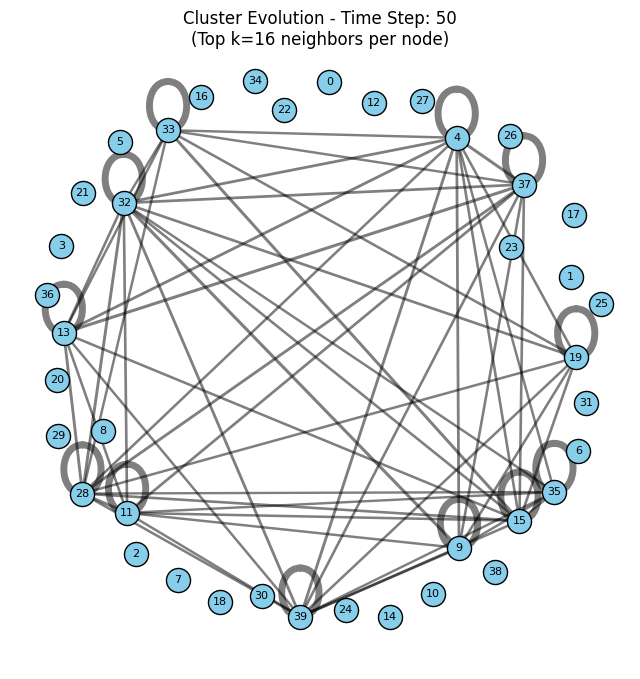

In [25]:
'''
To verify proper cluster assignments, full participation is required, since then only we can see most similar clients. 
'''

animate_evolution(data, k=16, filename='cifar_exp1.gif')